<a href="https://colab.research.google.com/github/AbeRodz/Machine-learning/blob/analisis_inicial/Analisis_inicial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install geopandas pyshp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/dataset/

/content/drive/MyDrive/dataset


In [ ]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
import shapefile as shp
import seaborn as sns
import numpy as np
import geopandas as gpd

In [ ]:
def open_sample_from_file(path : str,column_to_search: str = None , search_value:str = None, show_columns = False) -> pd.DataFrame:
    """
    Helper function to read a file sample with optional search conditions
    """
    parquet = path.endswith('parquet')
    func = getattr(pd, f'read_csv')
    if parquet:
        engine = 'auto'
        func = getattr(pd, f'read_parquet')
        return func(path, engine)
    
    if column_to_search:
        if search_value != None:
            df = func(path)
            return df[df[column_to_search] == search_value]
        
        return func(path)[column_to_search] 

    if show_columns:
        return func(path).columns

    return func(path)

In [ ]:
def open_season(path: str = "./dataset/",season: str = "winter", drop_values = True) -> pd.DataFrame:
    """
    Helper function to open and separate the dataset on seasons.
    """
    seasons = {"winter":[path + "yellow_tripdata_2022-01.parquet",path + "yellow_tripdata_2022-02.parquet"
                          ],
               "spring":[path +"yellow_tripdata_2022-03.parquet",path + "yellow_tripdata_2022-05.parquet"
                          ],
               "summer":[path + "yellow_tripdata_2022-06.parquet",path + "yellow_tripdata_2022-08.parquet"
                          ],
               "autumn" :[path + "yellow_tripdata_2022-09.parquet",path + "yellow_tripdata_2022-11.parquet"
                          ]
               }
    if season in seasons:
  
      df  = pd.concat(
      map(pd.read_parquet, seasons.get(season)), ignore_index=True)
      if drop_values:
        df = df.drop(['store_and_fwd_flag', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge'], axis=1)
      return df
    return False

In [ ]:
df = open_season(path = "",season= "winter")

In [ ]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'tip_amount',
       'tolls_amount', 'total_amount', 'airport_fee'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5443362 entries, 0 to 5443361
Data columns (total 14 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   PULocationID           int64         
 7   DOLocationID           int64         
 8   payment_type           int64         
 9   fare_amount            float64       
 10  tip_amount             float64       
 11  tolls_amount           float64       
 12  total_amount           float64       
 13  airport_fee            float64       
dtypes: datetime64[ns](2), float64(8), int64(4)
memory usage: 581.4 MB


## 2. Análisis exploratorio inicial

### Visualizar las primeras filas.

In [ ]:
df.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,142,236,1,14.5,3.65,0.0,21.95,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,236,42,1,8.0,4.00,0.0,13.30,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,166,166,1,7.5,1.76,0.0,10.56,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,114,68,2,8.0,0.00,0.0,11.80,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,68,163,1,23.5,3.00,0.0,30.30,0.0


## Realizar un resumen de 5 números.

In [ ]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,airport_fee
count,5.443362e+06,5.270121e+06,5.443362e+06,5.270121e+06,5.443362e+06,5.443362e+06,5.443362e+06,5.443362e+06,5.443362e+06,5.443362e+06,5.443362e+06,5.270121e+06
mean,1.709109e+00,1.390917e+00,5.635142e+00,1.419827e+00,1.657783e+02,1.635005e+02,1.183061e+00,1.304498e+01,2.448713e+00,3.793579e-01,1.934911e+01,7.766212e-02
std,5.017359e-01,9.836000e-01,6.015312e+02,5.972370e+00,6.554616e+01,7.058795e+01,4.975932e-01,1.723407e+02,2.808154e+00,1.675431e+00,1.725652e+02,3.038566e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-6.000000e+02,-1.880000e+02,-3.140000e+01,-6.003000e+02,-1.250000e+00
25%,1.000000e+00,1.000000e+00,1.060000e+00,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,6.500000e+00,1.000000e+00,0.000000e+00,1.175000e+01,0.000000e+00
50%,2.000000e+00,1.000000e+00,1.770000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.500000e+00,2.050000e+00,0.000000e+00,1.476000e+01,0.000000e+00
75%,2.000000e+00,1.000000e+00,3.170000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,1.400000e+01,3.060000e+00,0.000000e+00,2.047000e+01,0.000000e+00
max,6.000000e+00,9.000000e+00,3.487985e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,4.010923e+05,8.888800e+02,1.933000e+02,4.010956e+05,1.250000e+00


### Identificar los tipos de datos: categórico, ordinal, etc. Responder para cada variable su tipo y si es informativa para un problema de clasificación (por ejemplo si se trata de un código, como una matrícula, o un nombre propio).

In [ ]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
tip_amount                      float64
tolls_amount                    float64
total_amount                    float64
airport_fee                     float64
dtype: object

In [ ]:
df['VendorID'].value_counts()

2    3798002
1    1632961
6      12337
5         62
Name: VendorID, dtype: int64

In [ ]:
df['passenger_count'].value_counts()

1.0    3944723
2.0     763326
3.0     188228
0.0     114266
5.0     110394
4.0      76448
6.0      72700
8.0         18
7.0         12
9.0          6
Name: passenger_count, dtype: int64

In [ ]:
df['payment_type'].value_counts()

1    4171093
2    1051277
0     173241
3      24821
4      22928
5          2
Name: payment_type, dtype: int64

In [ ]:
df['RatecodeID'].value_counts()

1.0     5063607
2.0      143888
5.0       27662
99.0      19599
3.0        8884
4.0        6435
6.0          46
Name: RatecodeID, dtype: int64

| Nombre campo | Tipo de dato | Tipo | Significado
|-----------|-----------|-----------|-----------|
|VendorID              | int64      | Categórica | Empresa telefonía
|tpep_pickup_datetime  | datetime64 |Fecha/hora | Inicio viaje
|tpep_dropoff_datetime | datetime64 | Fecha/hora | Fin viaje
|passenger_count       | float64    |Numerica | Cantidad pasajeros
|trip_distance         | float64    |Numerica  | Distancia viaje
|RatecodeID            | float64    | Categórica | Codigo tarifa
|store_and_fwd_flag    | object     | Categórica | Se guardo en memoria 
|PULocationID          | int64      |Categórica | Id zona comienzo
|DOLocationID          | int64      |Categórica | Id zona fin
|payment_type          | int64      | Categórica | Forma de pago
|fare_amount           | float64    |Numerica | Monto del viaje
|extra                 | float64    |Numerica | Extras
|mta_tax               | float64    |Numerica | Impuesto MTA
|tip_amount            | float64    |Numerica | Propina
|tolls_amount          | float64    |Numerica | Monto peajes
|improvement_surcharge | float64    |Numerica | Recargo por mejoras
|total_amount          | float64    | Numerica| Monto total
|congestion_surcharge  | float64    | Numerica | Recargo por congestión
|airport_fee           | float64    |Numerica | Tarifa aeropuerto           |

### Identificar las variables de entrada y de salida del problema. 

### Variables de Entrada

| Nombre campo | Tipo de dato | Tipo | Significado
|-----------|-----------|-----------|-----------|
|tpep_pickup_datetime  | datetime64 |Fecha/hora | Inicio viaje
|tpep_dropoff_datetime | datetime64 | Fecha/hora | Fin viaje
|passenger_count       | float64    |Numerica | Cantidad pasajeros
|trip_distance         | float64    |Numerica  | Distancia viaje
|PULocationID          | int64      |Categórica | Id zona comienzo
|DOLocationID          | int64      |Categórica | Id zona fin
|payment_type          | int64      | Categórica | Forma de pago
|fare_amount           | float64    |Numerica | Monto del viaje calculado por el taximetro
|tip_amount            | float64    |Numerica | Propina
|tolls_amount          | float64    |Numerica | Monto peajes
|airport_fee           | float64    |Numerica | Tarifa aeropuerto           |



### Analisis por tipo de variable

### Numericas (distribucion de los datos)

In [ ]:
#sns.pairplot(df)

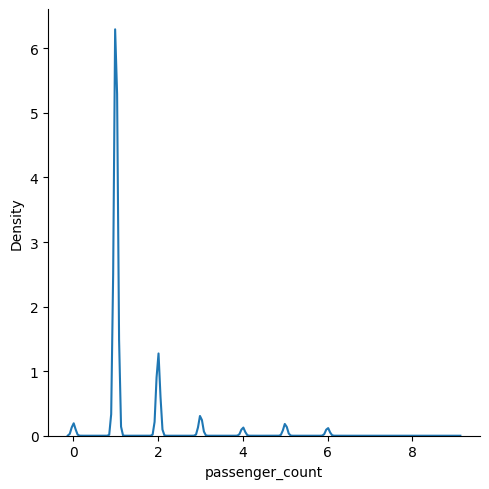

In [ ]:
sns.displot(df.passenger_count, kind= 'kde')

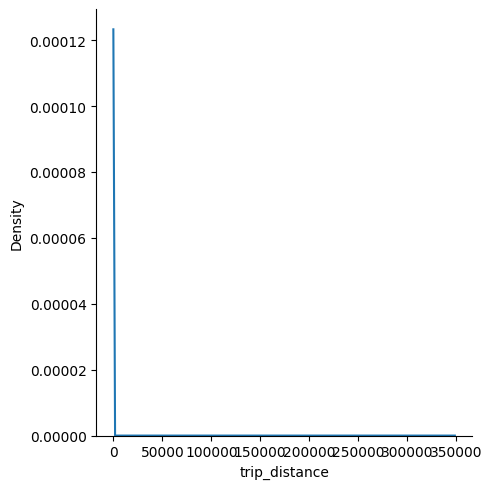

In [ ]:
sns.displot(df.trip_distance, kind= 'kde')

In [ ]:
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=8, ylabelsize=8,figsize=(18,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

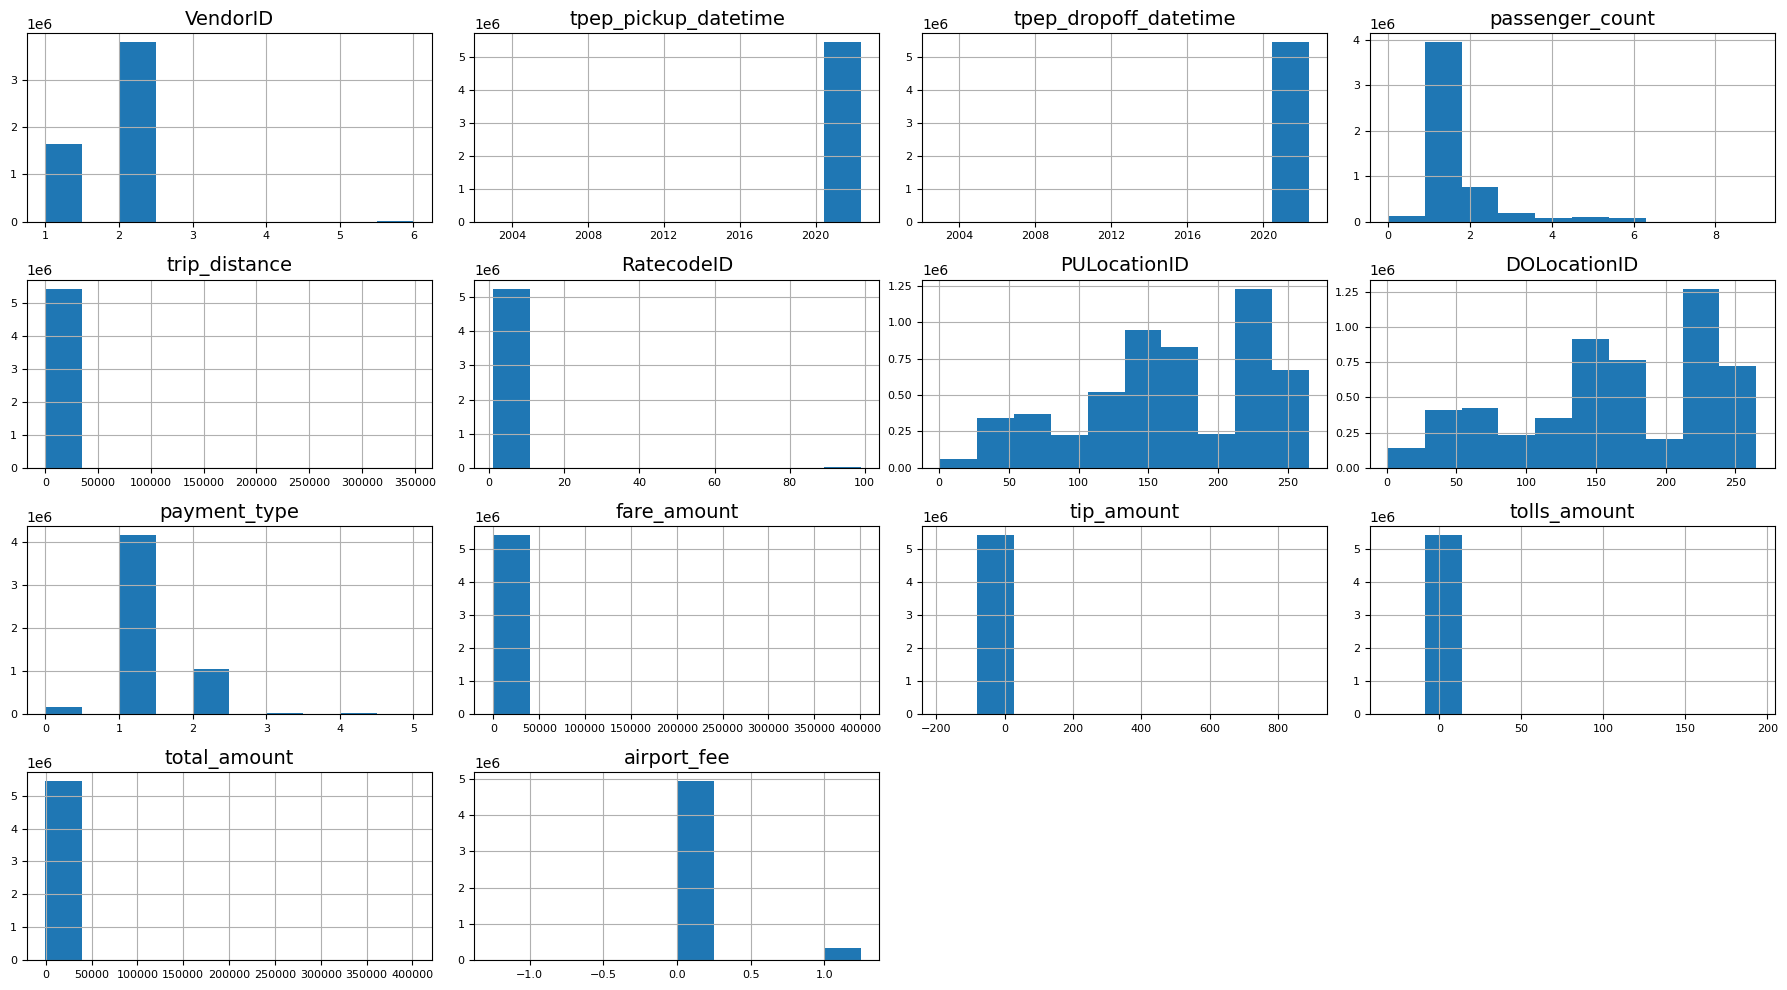

In [ ]:
display_dataset_distributions(df)

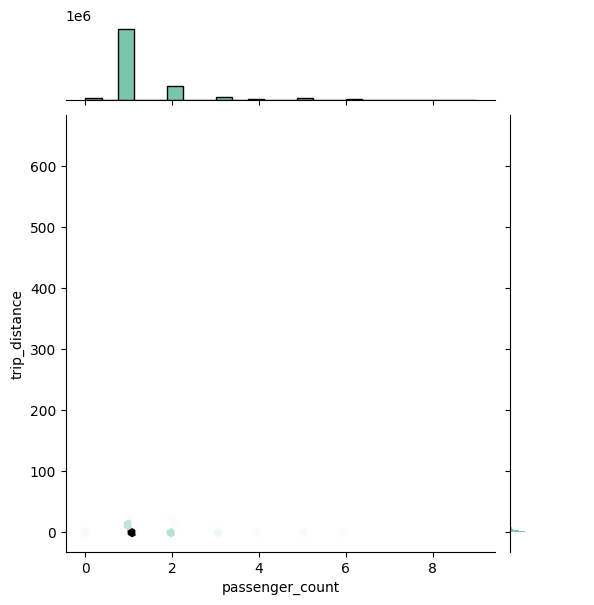

In [ ]:
sns.jointplot(x=df.passenger_count, y=df.trip_distance, kind="hex", color="#4CB391")

In [ ]:
df.total_amount.median()

14.76

In [ ]:
df.total_amount.mode()

0    10.8
Name: total_amount, dtype: float64

In [ ]:
df.total_amount.mean()

19.349111609700067

### Veamos total_amount cerca de la media

In [ ]:
df.total_amount.value_counts()

10.80     89436
10.30     89006
11.30     87734
9.80      85865
11.80     85636
          ...  
108.82        1
74.38         1
77.53         1
72.76         1
76.41         1
Name: total_amount, Length: 13441, dtype: int64

In [ ]:
df[(df.total_amount<0)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,airport_fee
154,2,2022-01-01 00:26:37,2022-01-01 00:39:35,1.0,7.38,1.0,132,265,4,-21.00,0.00,0.0,-23.55,-1.25
521,2,2022-01-01 00:27:18,2022-01-01 00:40:50,1.0,5.14,1.0,152,48,4,-17.00,0.00,0.0,-20.80,0.00
523,2,2022-01-01 00:59:33,2022-01-01 01:14:09,4.0,5.37,5.0,50,265,2,-75.00,0.00,0.0,-77.80,0.00
580,2,2022-01-01 00:16:58,2022-01-01 00:19:41,1.0,0.46,1.0,90,234,2,-4.00,0.00,0.0,-7.80,0.00
714,2,2022-01-01 00:29:12,2022-01-01 00:40:29,1.0,3.13,1.0,13,246,4,-12.00,0.00,0.0,-15.80,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5433236,2,2022-02-26 04:23:51,2022-02-26 04:26:37,NaN,0.10,NaN,255,255,0,-13.37,0.00,0.0,-12.57,NaN
5434829,2,2022-02-26 16:22:44,2022-02-26 16:23:56,NaN,0.02,NaN,230,230,0,-95.79,15.07,0.0,-77.42,NaN
5435416,2,2022-02-26 19:31:00,2022-02-26 19:32:00,NaN,0.00,NaN,246,246,0,-31.27,4.41,0.0,-23.56,NaN
5436871,2,2022-02-27 00:01:12,2022-02-27 00:02:58,NaN,0.02,NaN,114,114,0,-28.37,0.00,0.0,-25.07,NaN


In [ ]:
df[(df.total_amount>100)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,airport_fee
370,2,2022-01-01 00:38:48,2022-01-01 00:39:01,1.0,0.00,5.0,142,142,1,150.00,0.00,0.00,152.80,0.00
799,2,2022-01-01 00:35:56,2022-01-01 00:36:12,1.0,0.00,5.0,79,79,1,240.00,40.00,0.00,282.80,0.00
1114,1,2022-01-01 00:57:40,2022-01-01 01:19:49,1.0,11.30,5.0,239,265,1,80.00,40.00,0.00,120.30,0.00
1404,2,2022-01-01 00:32:59,2022-01-01 01:05:34,1.0,27.85,4.0,132,265,1,124.50,25.16,0.00,152.21,1.25
1451,2,2022-01-01 00:32:38,2022-01-01 01:10:42,1.0,16.99,5.0,48,265,1,100.00,10.00,11.75,124.55,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5439758,2,2022-02-27 18:10:00,2022-02-27 18:58:00,NaN,24.61,NaN,230,265,0,90.04,22.95,20.25,136.54,NaN
5439809,2,2022-02-27 18:26:10,2022-02-27 19:17:38,NaN,13.68,NaN,40,132,0,80.45,19.29,0.00,100.54,NaN
5441239,2,2022-02-28 08:13:37,2022-02-28 08:46:47,NaN,17.18,NaN,142,1,0,68.42,16.25,13.75,101.72,NaN
5442318,2,2022-02-28 16:26:56,2022-02-28 17:14:56,NaN,17.89,NaN,161,1,0,67.28,17.79,18.75,107.12,NaN


In [ ]:
df[df.total_amount<0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,airport_fee
154,2,2022-01-01 00:26:37,2022-01-01 00:39:35,1.0,7.38,1.0,132,265,4,-21.00,0.00,0.0,-23.55,-1.25
521,2,2022-01-01 00:27:18,2022-01-01 00:40:50,1.0,5.14,1.0,152,48,4,-17.00,0.00,0.0,-20.80,0.00
523,2,2022-01-01 00:59:33,2022-01-01 01:14:09,4.0,5.37,5.0,50,265,2,-75.00,0.00,0.0,-77.80,0.00
580,2,2022-01-01 00:16:58,2022-01-01 00:19:41,1.0,0.46,1.0,90,234,2,-4.00,0.00,0.0,-7.80,0.00
714,2,2022-01-01 00:29:12,2022-01-01 00:40:29,1.0,3.13,1.0,13,246,4,-12.00,0.00,0.0,-15.80,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5433236,2,2022-02-26 04:23:51,2022-02-26 04:26:37,NaN,0.10,NaN,255,255,0,-13.37,0.00,0.0,-12.57,NaN
5434829,2,2022-02-26 16:22:44,2022-02-26 16:23:56,NaN,0.02,NaN,230,230,0,-95.79,15.07,0.0,-77.42,NaN
5435416,2,2022-02-26 19:31:00,2022-02-26 19:32:00,NaN,0.00,NaN,246,246,0,-31.27,4.41,0.0,-23.56,NaN
5436871,2,2022-02-27 00:01:12,2022-02-27 00:02:58,NaN,0.02,NaN,114,114,0,-28.37,0.00,0.0,-25.07,NaN


In [ ]:
def plot_distribution_with_info(df:pd.DataFrame,col_name = None, show_info = True, filter = None):
  if col_name is None:
    return
    
  df = df[(df[col_name]<=100) & (df[col_name]>=0)][col_name]

  if filter is not None:
    df = filter

  sns.displot(df, kind = 'kde')
  if show_info:
    plt.axvline(x=df.mean(),
                color='red')
    plt.axvline(x=df.median(),
                color='blue',
                ls='--', 
                lw=2.5)

In [ ]:
def plot_all(df):
    fig = plot_distribution_with_info(df)
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

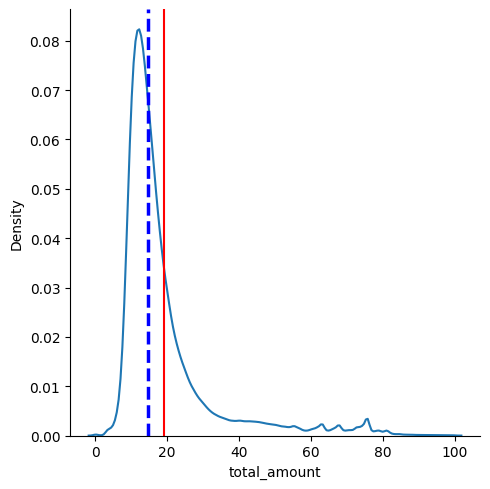

In [ ]:
plot_distribution_with_info(df,"total_amount")

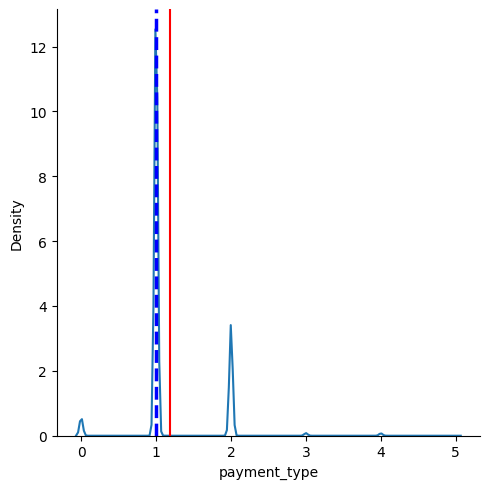

In [ ]:
plot_distribution_with_info(df,"payment_type")

In [ ]:
trip_filter = df[(df["trip_distance"]<=50)]["trip_distance"]

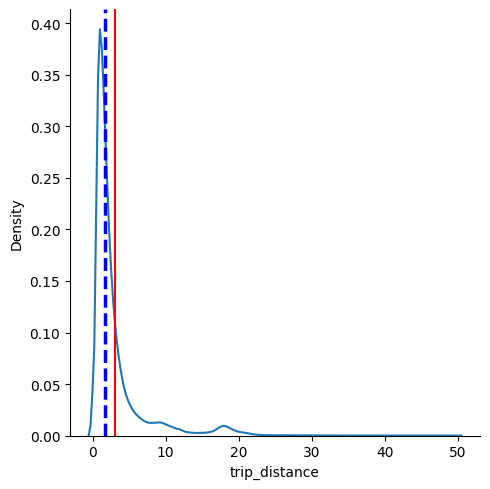

In [ ]:
plot_distribution_with_info(df,"trip_distance", filter = trip_filter )

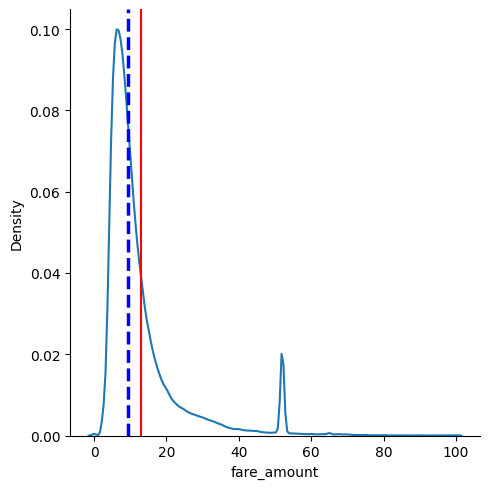

In [ ]:
plot_distribution_with_info(df,"fare_amount")

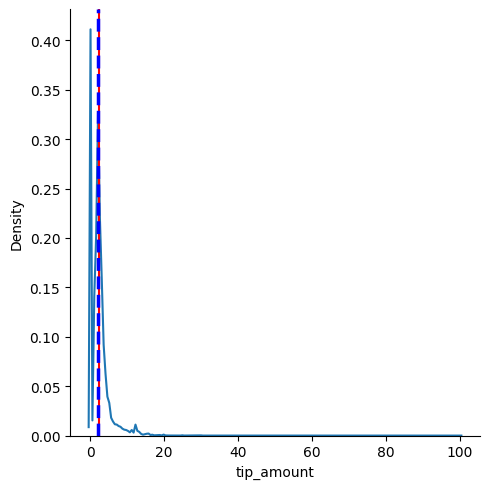

In [ ]:
plot_distribution_with_info(df,"tip_amount")

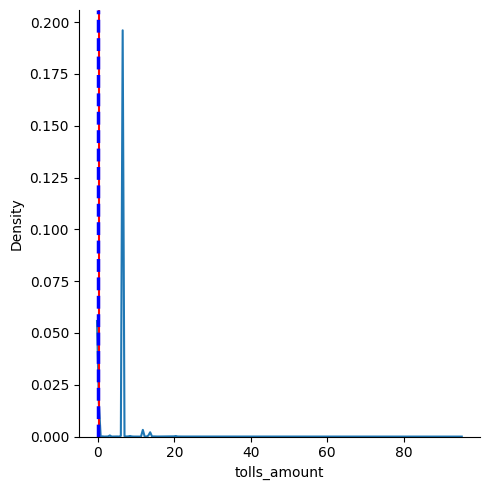

In [ ]:
plot_distribution_with_info(df,"tolls_amount")

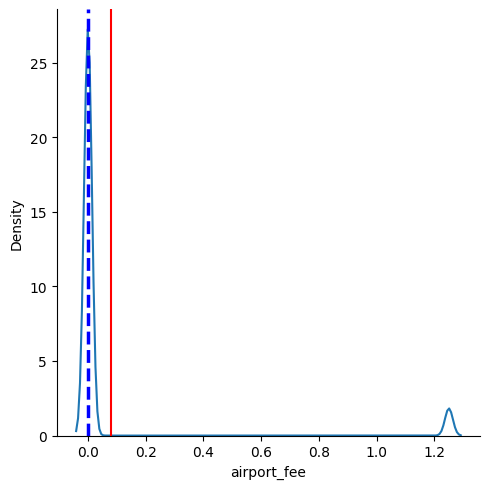

In [ ]:
plot_distribution_with_info(df,"airport_fee")

### De las variables tpep_pickup_datetime tpep_dropoff_datetime  se puede obtener mas data, al distribuirla por hora, fecha, duracion de la trayectoria

In [ ]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['date'] = df['tpep_pickup_datetime'].dt.normalize()
df['time'] = df['tpep_pickup_datetime'].dt.hour
df['weekday'] = df['date'].dt.day_name()
df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['duration'] = df['duration'] / np.timedelta64(1, 'm')

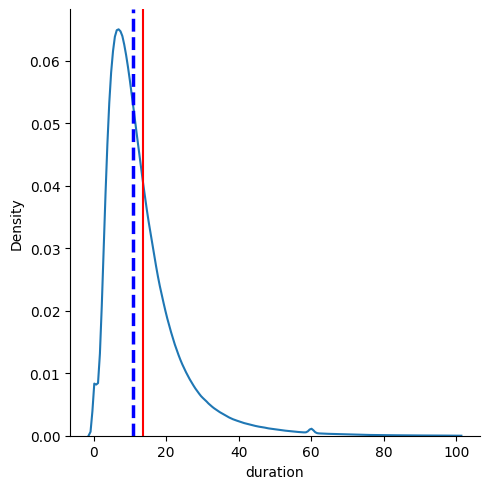

In [ ]:
plot_distribution_with_info(df,"duration")

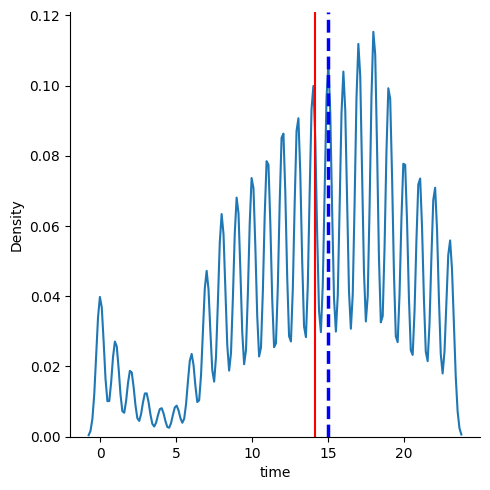

In [ ]:
plot_distribution_with_info(df,"time")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5443362 entries, 0 to 5443361
Data columns (total 18 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   PULocationID           int64         
 7   DOLocationID           int64         
 8   payment_type           int64         
 9   fare_amount            float64       
 10  tip_amount             float64       
 11  tolls_amount           float64       
 12  total_amount           float64       
 13  airport_fee            float64       
 14  duration               float64       
 15  date                   datetime64[ns]
 16  time                   int64         
 17  weekday                object        
dtypes: datetime64[ns](3), 

### Variables de Salida
| Nombre campo | Tipo de dato | Tipo | Significado
|-----------|-----------|-----------|-----------|
|total_amount          | float64    | Numerica| Monto total


### ¿Estan balanceadas las clases?
R/ Si

## 3. Limpieza y preparación de datos / ingeniería de features 

### Datos faltantes. Indicar cantidad de observaciones y valores faltantes para cada variable. 

In [ ]:
df.isna().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          173241
trip_distance                 0
RatecodeID               173241
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
tip_amount                    0
tolls_amount                  0
total_amount                  0
airport_fee              173241
dtype: int64

¿Qué supuestos puede realizar acerca de los datos faltantes? ¿Qué técnicas de imputación 
recomendaría? Ensayar distintas técnicas y analizar los resultados. 

### En función del estudio inicial de las variables que se hizo en la sección anterior, elegir una técnica de codificación para cada variable. Cuando lo considere apropiado, ensayar distintas técnicas y comparar los resultados, teniendo en cuenta el tipo de clasificador a utilizar. Nota: para tipos de  datos compuestos o estructurados, considerar la obtención de variables de tipo numérico/categórico.

¿Qué puede decir acerca de las relaciones entre las variables de entrada?
|

Antes de entrenar un modelo de aprendizaje automático, ¿Podría identificar las variables de 
entrada de mayor importancia? Considerar por lo menos dos técnicas para cada variable. Explique 
brevemente los métodos utilizados